In [1]:
import pandas as pd
import numpy as np
import os
import glob
from PopSynthesis.Benchmark.CompareCensus.utils import convert_full_to_marg_count, impute_new_marg

In [2]:
folder_loc = "data/synpop_related"

### Doing the converge results

In [3]:
rm_hh_for_each = { # this is manually created for now
    "SAA_BN_pool": [2420220.0, 730187, 224061, 68546, 22152, 7977, 3768, 2607, 2277, 2205, 2186, 2165, 2158, 2156, 2150],
    "SAA_seed_addzero": [2420220.0, 728935, 220907, 69213, 26652, 20147, 8181, 8091, 8056, 4585, 4581, 4576, 3553, 3308, 3308],
    "SAA_seed_misszero": [2420220.0, 728867, 221112, 69035, 26847, 20260, 19801, 19707, 19682, 19660, 19652, 19644, 19640, 19636, 19632],
}
color_code = {
    "SAA_BN_pool": "#1f77b4",
    "SAA_seed_addzero": "#ff7f0e",
    "SAA_seed_misszero": "#2ca02c"
}

<Axes: xlabel='run', ylabel='removed households'>

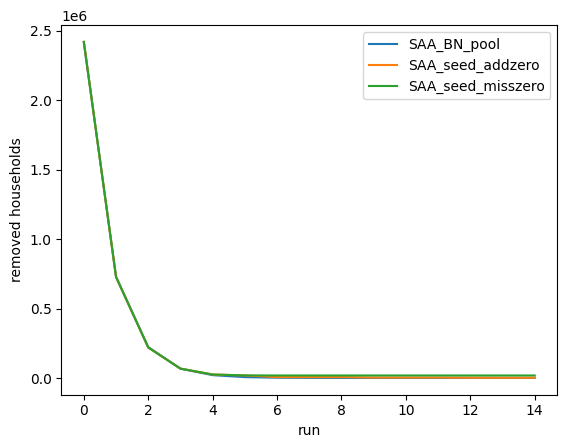

In [4]:
rm_hh_df = pd.DataFrame(rm_hh_for_each)
rm_hh_df.plot(kind="line", xlabel="run", ylabel="removed households", color=[color_code[col] for col in rm_hh_df.columns])

<Axes: xlabel='run', ylabel='removed households'>

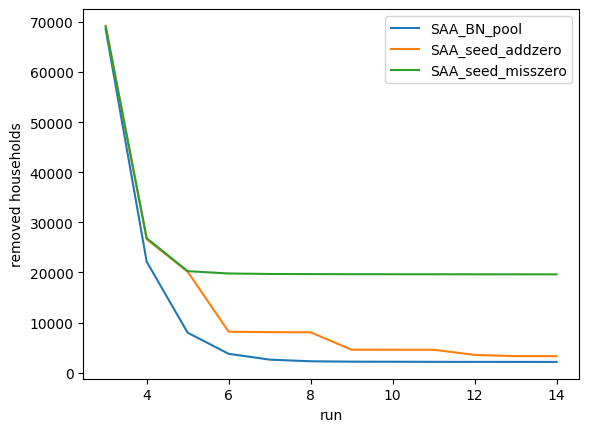

In [5]:
rm_hh_df[3:].plot(kind="line", xlabel="run", ylabel="removed households", color=[color_code[col] for col in rm_hh_df.columns])

### First and last run order for BN Pool

find all csv
seperate the get the one att it adjusted and for what run
get the name
we will store a data struct to have the name to an array of dictionary of value to csv.name
we also match a name to find the first last one adjust for each run 
except the case of 
function to calculate the attributes RMSE

In [6]:
census_data = pd.read_csv(os.path.join(folder_loc, "hh_marginals_ipu.csv"), header=[0,1])
# Extract the total and studied attributes
special_cols = {"zone_id", "sample_geog"}
studied_atts = set(census_data.columns.get_level_values(0)) - special_cols
# census_data.columns = census_data.columns.to_flat_index()
zone_id_col = [col for col in census_data.columns if col[0] == "zone_id"][0]
other_cols = [col for col in census_data.columns if col[0] in special_cols and col[0] != "zone_id"]
assert census_data[zone_id_col].nunique() == census_data.shape[0]
census_data = census_data.set_index(zone_id_col)
census_data = census_data.drop(columns=other_cols)
census_data

hhsize                                   \
                                   1     2     3    4    5   6  7  8+   
(zone_id, Unnamed: 0_level_1)                                           
3000                           10393  8524  2026  656  118  27  4  58   
3002                            1035  1019   190  101   38   9  0  55   
3003                            1504  1591   476  223   40  11  7  55   
3004                            2566  2382   511  227   33   6  5  55   
3006                            5113  5033  1280  414   59  13  8  58   
...                              ...   ...   ...  ...  ...  .. ..  ..   
3990                               6    20     8    4    3   0  0  55   
3991                              37    65    16   19   10   9  0  55   
3992                             134   201    72   60   24   9  0  55   
3995                            1663  1834   629  451  228  73  8  58   
3996                             806  1176   251  299  137  31  6  59   

                                      dwelltype          ...      hhinc  \
                              Flat or Apartment Missing  ... Nil income   
(zone_id, Unnamed: 0_level_1)                            ...              
3000                                      21546     128  ...       1916   
3002                                       1877       9  ...         42   
3003                                       3187       6  ...        159   
3004                                       5741      27  ...        172   
3006                                      11783      40  ...        435   
...                                         ...     ...  ...        ...   
3990                                          0       0  ...          3   
3991                                          0       0  ...          6   
3992                                          0       0  ...          9   
3995                                         25       8  ...         87   
3996                                         12       4  ...         55   

                              totalvehs                              owndwell  \
                                      0     1     2    3   4+ Being Purchased   
(zone_id, Unnamed: 0_level_1)                                                   
3000                              14688  5445   861  397  415            2453   
3002                                478  1268   545   89   67             434   
3003                               1401  1937   420   93   56             797   
3004                               1198  3442   882  168   95            1207   
3006                               4725  5884  1026  193  150            2136   
...                                 ...   ...   ...  ...  ...             ...   
3990                                 13    12    30   25   16              16   
3991                                 20    46    66   42   37              51   
3992                                 12   153   218   93   79             229   
3995                                380  1949  1692  585  338            1326   
3996                                 88  1040  1207  298  132             690   

                                                                       
                              Being Rented Fully Owned Something Else  
(zone_id, Unnamed: 0_level_1)                                          
3000                                 16601        2284            468  
3002                                  1298         673             42  
3003                                  2548         463             99  
3004                                  3212        1268             98  
3006                                  8092        1537            213  
...                                    ...         ...            ...  
3990                                     0          22             58  
3991                                    17          67             76  
3992                         

In [7]:
def calculate_rmse(file_loc, marg):
    df = pd.read_csv(file_loc)
    df = convert_full_to_marg_count(df)
    df = impute_new_marg(marg, df)
    result = df.mean(axis=0).apply(np.sqrt)
    result.index.set_names(["Attribute", "State"], inplace=True)
    return result

In [8]:
n_run = 15
data_folder = "data/converge_results"
# find all csv files
csv_files = glob.glob(data_folder + "/*.csv")

check_file = {}
for file in csv_files:
    name = file.split("/")[-1].split("\\")[-1].split(".")[0].replace("syn_pop_adjusted_", "")
    name_split = name.split("_")
    adjusted_att = name_split[0]
    run_order = name_split[-1]
    method_name = "_".join(name_split[1:-1])
    if method_name not in check_file:
        check_file[method_name] = [{} for _ in range(n_run)]
    check_file[method_name][int(run_order)][adjusted_att] = file

In [9]:
first_order_for_BN = ['hhinc', 'hhsize', 'dwelltype', 'totalvehs', 'owndwell']
last_order_for_all = ['hhsize', 'totalvehs', 'hhinc', 'dwelltype', 'owndwell']

In [10]:
updated_results = {}
for method_name, run_files in check_file.items():
    hold_out = [None for _ in range(len(run_files))]
    for run_order, run_files in enumerate(run_files):
        hold = {}
        for adjusted_att, file_loc in run_files.items():
            hold[adjusted_att] = calculate_rmse(file_loc, census_data)
        hold_df = pd.DataFrame(hold)
        hold_df = hold_df.reset_index()
        hold_df = hold_df.drop(columns=["State"]).groupby("Attribute").mean()
        hold_out[run_order] = hold_df
    updated_results[method_name] = hold_out

C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_26456\2340832763.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_loc)
C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_26456\2340832763.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_loc)
C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_26456\2340832763.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_loc)


<Axes: xlabel='Attribute', ylabel='RMSE'>

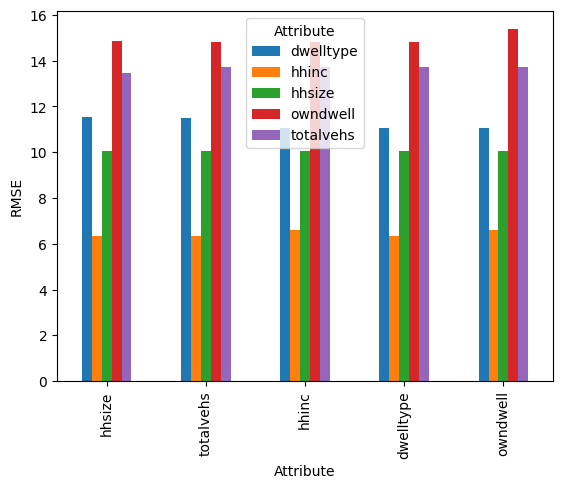

In [11]:
check_SAA_BN_first = updated_results["BN_new2"][1]
a = check_SAA_BN_first.copy()
a = a.reindex(last_order_for_all, axis=1)
a.T.plot(kind="bar", xlabel="Attribute", ylabel="RMSE")

In [12]:
updated_results_mean = {}
for name, run_items in updated_results.items():
    updated_results_mean[name] = [df.mean().min() for df in run_items] 

<Axes: xlabel='run', ylabel='RMSE'>

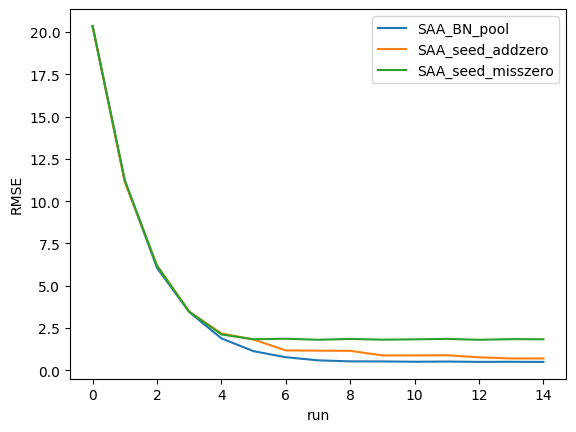

In [13]:
temp = pd.DataFrame(updated_results_mean)
temp = temp.rename(columns={"BN_new2": "SAA_BN_pool", "oriseed_paper_addzero": "SAA_seed_addzero", "oriseed_paper_misszero": "SAA_seed_misszero"})
temp.plot(kind="line", xlabel="run", ylabel="RMSE", color=[color_code[col] for col in temp.columns])

<Axes: xlabel='run', ylabel='RMSE'>

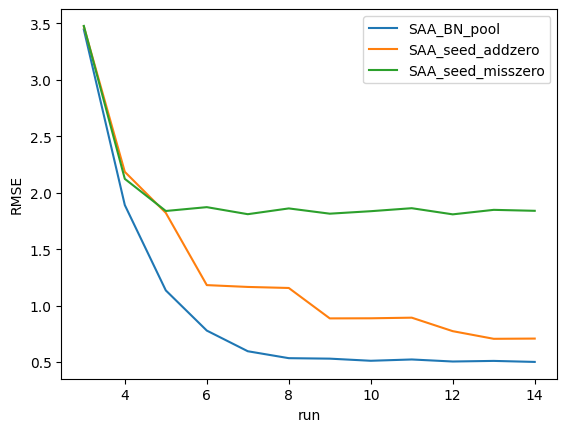

In [14]:
temp[3:].plot(kind="line", xlabel="run", ylabel="RMSE", color=[color_code[col] for col in temp.columns])